In [5]:
import tensorflow as tf
import numpy as np
import gpflow
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, clear_output
import networkx as nx
from gpflow.utilities import print_summary
import tensorflow_probability as tfp
import seaborn as sns

2025-09-14 23:41:21.352457: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-09-14 23:41:21.364792: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1757889681.378750 2634533 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1757889681.383531 2634533 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1757889681.394101 2634533 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [8]:
import sys
import os
project_root = os.path.abspath("../..")
sys.path.append(project_root)

In [9]:
# Function to clear GPU memory cache
def clear_gpu_memory():
    """Clear GPU memory cache to free up memory"""
    if tf.config.list_physical_devices('GPU'):
        tf.keras.backend.clear_session()
        tf.compat.v1.reset_default_graph()
        import gc
        gc.collect()
        print("GPU memory cleared")

In [10]:
from efficient_graph_gp.graph_kernels import diffusion_kernel, get_normalized_laplacian, generate_noisy_samples
from efficient_graph_gp.gpflow_kernels import GraphDiffusionKernel, GraphGeneralPoFMKernel, GraphGeneralFastGRFKernel
from utils import plot_network_graph, plot_gp_fit, compute_fro

### Helper Functions

In [ ]:
def gp_inference(X,Y,X_new, graph_kernel):
    model = gpflow.models.GPR(data=(X, Y), kernel=graph_kernel, mean_function=None)
    # model.likelihood.variance.prior = tfp.distributions.LogNormal(loc=np.log(0.07), scale=0.5)
    gpflow.optimizers.Scipy().minimize(model.training_loss, model.trainable_variables)
    mean, variance = model.predict_f(X_new)
    stddev = tf.sqrt(variance)
    return model, mean, stddev

def plot_noisy_3d(Y_noisy, mesh_size, cmap='viridis', cbar_shrink=0.6, cbar_aspect=20, cbar_pad=0.05, dpi=150):
    """
    Plots a 3D surface of the noisy sampled data on a 2D grid.

    Parameters:
    - Y_noisy: 1D or 2D array-like of noisy sampled data.
    - mesh_size: The size of one dimension of the square mesh grid.
    - cmap: Colormap for the surface plot (default 'viridis').
    - cbar_shrink: Height of the colorbar relative to the plot (default 0.6).
    - cbar_aspect: Width of the colorbar (default 20, higher = thinner).
    - cbar_pad: Distance between plot and colorbar (default 0.05).
    - dpi: Dots per inch for plot resolution (default 150).
    """
    # Prepare the grid for plotting
    x = np.arange(mesh_size)
    y = np.arange(mesh_size)
    X, Y = np.meshgrid(x, y)

    # Reshape Y_noisy to a 2D grid if needed
    Z = np.array(Y_noisy).reshape(mesh_size, mesh_size)

    # Create a 3D figure and axis
    fig = plt.figure(dpi=dpi)
    ax = fig.add_subplot(111, projection='3d')

    # Plot the surface
    surf = ax.plot_surface(X, Y, Z, cmap=cmap)

    # Add a customizable color bar
    cbar = fig.colorbar(surf, shrink=cbar_shrink, aspect=cbar_aspect, pad=cbar_pad)
    cbar.set_label('')  # Remove label

    # Set labels and title
    ax.set_xlabel('X-axis')
    ax.set_ylabel('Y-axis')
    ax.set_zlabel('Noisy Data Value')
    plt.title('Noisy Sampled Data in 3D')

    plt.show()
    
def plot_gp_with_subsamples(Y_full, mesh_size, subsample_idx, Y_subsampled, 
                            title='GP Surface with Subsampled Data', cmap='viridis',
                            cbar_shrink=0.6, cbar_aspect=20, cbar_pad=0.05, dpi=150):
    """
    Plots a 3D GP surface with overlaid subsampled data points.

    Parameters:
    -----------
    Y_full : array-like
        The full set of GP predictions or true values on a grid as a 1D array of length mesh_size**2.
    mesh_size : int
        The size of one dimension of the mesh grid (assuming a square grid).
    subsample_idx : array-like
        Indices of the subsampled points within the grid (flattened index).
    Y_subsampled : array-like
        Values corresponding to the subsampled data points.
    title : str, optional
        Title for the plot. Default is 'GP Surface with Subsampled Data'.
    cmap : str, optional
        Colormap for the surface. Default is 'viridis'.
    cbar_shrink : float, optional
        Height of the colorbar relative to the plot (default 0.6).
    cbar_aspect : float, optional
        Width of the colorbar (default 20, higher = thinner).
    cbar_pad : float, optional
        Distance between plot and colorbar (default 0.05).
    dpi : int, optional
        Dots per inch for plot resolution (default 150).

    Returns:
    --------
    None
        Displays a 3D plot.
    """
    # Convert inputs to numpy arrays
    Y_full = np.array(Y_full)
    subsample_idx = np.array(subsample_idx)
    Y_subsampled = np.array(Y_subsampled)

    # Verify that Y_full length matches mesh_size^2
    if Y_full.size != mesh_size**2:
        raise ValueError("Length of Y_full does not match mesh_size squared.")

    # Create the grid for the full surface
    x = np.arange(mesh_size)
    y = np.arange(mesh_size)
    X_grid, Y_grid = np.meshgrid(x, y)
    
    # Reshape the full surface data
    Z_full = Y_full.reshape(mesh_size, mesh_size)

    # Create a 3D plot
    fig = plt.figure(figsize=(10, 7), dpi=dpi)
    ax = fig.add_subplot(111, projection='3d')

    # Plot the full GP surface
    surf = ax.plot_surface(X_grid, Y_grid, Z_full, cmap=cmap, edgecolor='none', alpha=0.8)
    cbar = fig.colorbar(surf, shrink=cbar_shrink, aspect=cbar_aspect, pad=cbar_pad)
    cbar.set_label('')  # Remove label

    # Compute the grid coordinates for subsampled points
    subsampled_y = subsample_idx // mesh_size
    subsampled_x = subsample_idx % mesh_size
    subsampled_z = Y_subsampled.flatten()

    # Overlay the subsampled data points with black diamonds
    ax.scatter(subsampled_x, subsampled_y, subsampled_z, 
              color='black', s=10, marker='D', alpha=0.8)

    # Set labels and title
    ax.set_xlabel('X1')
    ax.set_ylabel('X2')
    ax.set_zlabel('Value')
    # ax.set_title(title)

    # Optionally adjust the viewing angle
    ax.view_init(elev=30, azim=225)  # Modify as needed

    plt.show()

def plot_error_field(Y_true, Y_pred, mesh_size, observation_positions=None, title='Error Field', cmap='coolwarm',
                    cbar_shrink=0.6, cbar_aspect=20, cbar_pad=0.05, dpi=150):
    """
    Plots the error field between true and predicted values on a 2D grid.

    Parameters:
    -----------
    Y_true : array-like
        The true values on a grid as a 1D array of length mesh_size**2.
    Y_pred : array-like
        The predicted values on a grid as a 1D array of length mesh_size**2.
    mesh_size : int
        The size of one dimension of the mesh grid (assuming a square grid).
    observation_positions : array-like, optional
        Indices of the observed points within the grid (flattened index).
    title : str, optional
        Title for the plot. Default is 'Error Field'.
    cmap : str, optional
        Colormap for the error field. Default is 'coolwarm'.
    cbar_shrink : float, optional
        Height of the colorbar relative to the plot (default 0.6).
    cbar_aspect : float, optional
        Width of the colorbar (default 20, higher = thinner).
    cbar_pad : float, optional
        Distance between plot and colorbar (default 0.05).
    dpi : int, optional
        Dots per inch for plot resolution (default 150).

    Returns:
    --------
    None
        Displays a 2D contour plot.
    """

    # Convert inputs to numpy arrays
    Y_true = np.array(Y_true).reshape(-1)
    Y_pred = np.array(Y_pred).reshape(-1)

    # Verify that Y_true and Y_pred lengths match mesh_size^2
    if Y_true.size != mesh_size**2 or Y_pred.size != mesh_size**2:
        raise ValueError("Length of Y_true or Y_pred does not match mesh_size squared.")

    # Compute the error field
    error_field = np.abs(Y_true - Y_pred)

    # Create the grid for the error field
    x = np.linspace(0, mesh_size - 1, mesh_size)
    y = np.linspace(0, mesh_size - 1, mesh_size)
    X_grid, Y_grid = np.meshgrid(x, y)

    # Reshape the error field
    Z_error = error_field.reshape(mesh_size, mesh_size)

    # Create a 2D contour plot
    fig, ax = plt.subplots(figsize=(10, 7), dpi=dpi)

    # Plot the contour
    contour = ax.contourf(X_grid, Y_grid, Z_error, levels=25, cmap=cmap)
    cbar = fig.colorbar(contour, ax=ax, shrink=cbar_shrink, aspect=cbar_aspect, pad=cbar_pad)
    cbar.set_label('')  # Remove label

    # Overlay the observation positions as black scatter points
    if observation_positions is not None:
        obs_y = observation_positions // mesh_size
        obs_x = observation_positions % mesh_size
        ax.scatter(obs_x, obs_y, color='k', s=50, label='Observed Data', marker='x')

    # Add labels and title
    ax.set_xlabel('X-axis')
    ax.set_ylabel('Y-axis')
    ax.set_title(title)
    if observation_positions is not None:
        ax.legend()

    # Show the plot
    plt.show()


### Graph Setup

In [12]:
# Parameters - reduced mesh size to manage memory
mesh_size = 30  # Reduced from 40 to manage GPU memory
num_nodes = mesh_size**2
graph_type = '2D_mesh' # 'line', 'random', '2D_mesh'

In [13]:
if graph_type == 'line':
    adjacency_matrix = np.eye(num_nodes, k=1) + np.eye(num_nodes, k=-1)  # Circular adjacency matrix
elif graph_type == 'random':
    probability = 0.1  # Probability of edge creation
    G = nx.erdos_renyi_graph(num_nodes, probability, directed=False)  # Ensure the graph is undirected
    adjacency_matrix = nx.to_numpy_array(G)  # Convert to adjacency matrix
elif graph_type == '2D_mesh':
    adjacency_matrix = nx.adjacency_matrix(nx.grid_2d_graph(mesh_size, mesh_size)).todense()
    

In [14]:
beta_sample = 10
noise_std = 0.1

In [15]:
K_true = diffusion_kernel(adjacency_matrix, beta_sample)
Y = generate_noisy_samples(K_true, noise_std=0, seed=0)
Y_noisy = generate_noisy_samples(K_true,noise_std=noise_std, seed=0)
X = tf.convert_to_tensor(np.arange(num_nodes, dtype=np.float64).reshape(-1, 1))  # Input features (nodes)

# Randomly subsample the data
subsample_factor = 10
subsample_idx = np.random.choice(num_nodes, num_nodes//subsample_factor, replace=False)

X_subsampled = X.numpy()[subsample_idx]
Y_noisy_subsampled = Y_noisy[subsample_idx]

I0000 00:00:1757889717.867035 2634533 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9617 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:17:00.0, compute capability: 7.5
I0000 00:00:1757889717.868445 2634533 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 9617 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:b3:00.0, compute capability: 7.5


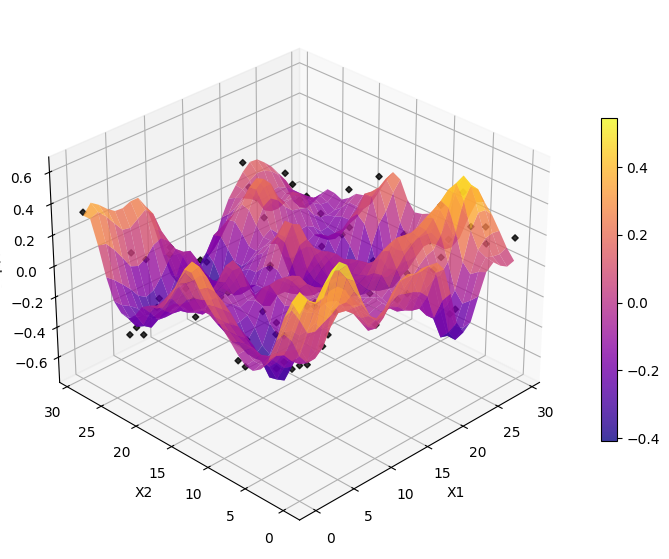

In [22]:
# Plot the GP surface with overlaid subsampled data
plot_gp_with_subsamples(Y, mesh_size, subsample_idx, Y_noisy_subsampled,
                        title='Ground Truth GP Surface with Noisy Samples', cmap='plasma')

In [50]:
WALKS_PER_NODE = 10000
P_HALT = 0.01
MAX_WALK_LENGTH = 10

In [51]:
X_train = tf.convert_to_tensor(X_subsampled)
Y_train = tf.convert_to_tensor(Y_noisy_subsampled.reshape(-1, 1))
X_full = X

### Diffusion

In [52]:
graph_kernel = GraphDiffusionKernel(adjacency_matrix)
model, mean, stddev = gp_inference(X_train, Y_train, X_full, graph_kernel)
print_summary(model)

╒═════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤════════════╕
│ name                    │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │      value │
╞═════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪════════════╡
│ GPR.kernel.beta         │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 14.0624    │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼────────────┤
│ GPR.kernel.sigma_f      │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │  1.10095   │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼────────────┤
│ GPR.likelihood.variance │ Parameter │ Softplus + Shift │         │ True        │ ()      │ float64 │  0.0131826 │
╘═════════════════════════╧═══════════╧══════════════════╧═════════╧════

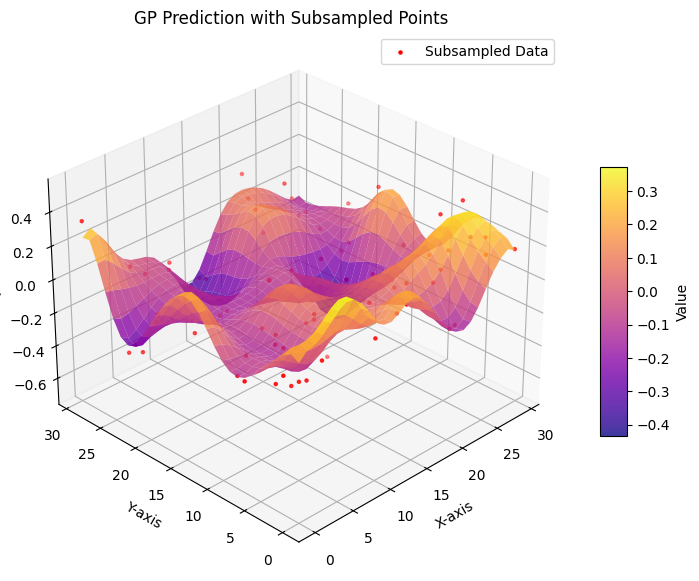

In [53]:
plot_gp_with_subsamples(mean.numpy(), mesh_size, subsample_idx, Y_noisy_subsampled,
                        title='GP Prediction with Subsampled Points', cmap='plasma')

In [54]:
# calculate the MSE

test_idx = np.setdiff1d(np.arange(num_nodes), subsample_idx)

Y_test = Y[test_idx]
mean_test = mean.numpy()[test_idx]

mse = np.mean((Y_test - mean_test.flatten())**2)
rmse = np.sqrt(mse)
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")

# calculate log marginal likelihood
log_marginal_likelihood = model.log_marginal_likelihood().numpy()
print(f"Log Marginal Likelihood: {log_marginal_likelihood:.4f}")

# --- NLPD (observation space) ---
# Use predict_y to include learned noise variance
mean_y, var_y = model.predict_y(X_full)
mean_y = mean_y.numpy().flatten()[test_idx]
var_y = var_y.numpy().flatten()[test_idx]
obs_true = Y_noisy[test_idx]
var_y = np.clip(var_y, 1e-12, None)
logp = -0.5 * (np.log(2 * np.pi * var_y) + (obs_true - mean_y) ** 2 / var_y)
nlpd = -np.mean(logp)
print(f"NLPD: {nlpd:.4f}")

MSE: 0.0544
RMSE: 0.2332
Log Marginal Likelihood: 26.2605
NLPD: 0.4049
NLPD: 0.4049


### GRFs

In [55]:
# Clear GPU memory before running experiments
clear_gpu_memory()

GPU memory cleared


In [56]:
# note the modulator vector is randomly initialized
graph_kernel = GraphGeneralFastGRFKernel(adjacency_matrix,
                                         walks_per_node=WALKS_PER_NODE,
                                         p_halt=P_HALT,
                                         max_walk_length=MAX_WALK_LENGTH,
                                         use_tqdm=True,
                                         ablation=False)

model, mean, stddev = gp_inference(X_train, Y_train, X_full, graph_kernel)
print_summary(model)

Process walks:   0%|          | 0/45 [00:00<?, ?it/s]

Process walks: 100%|██████████| 45/45 [02:26<00:00,  3.26s/it]


╒═════════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤═════════════════════════════════════════════════════╕
│ name                        │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │ value                                               │
╞═════════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪═════════════════════════════════════════════════════╡
│ GPR.kernel.modulator_vector │ Parameter │ Identity         │         │ True        │ (10,)   │ float64 │ [6.26327360e-01, -9.61329125e-01, 1.80370676e-01... │
├─────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼─────────────────────────────────────────────────────┤
│ GPR.likelihood.variance     │ Parameter │ Softplus + Shift │         │ True        │ ()      │ float64 │ 1.9658759422309896e-06                              │
╘═════════════════════════════╧═══

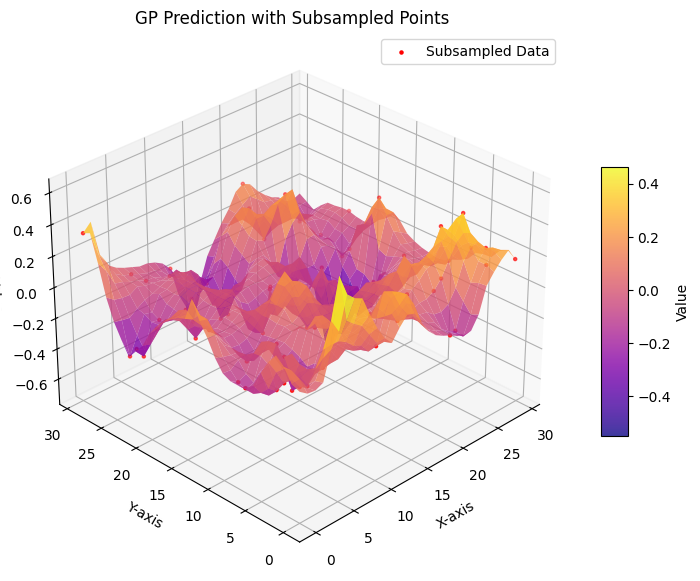

In [57]:
plot_gp_with_subsamples(mean.numpy(), mesh_size, subsample_idx, Y_noisy_subsampled,
                        title='GP Prediction with Subsampled Points', cmap='plasma')

In [58]:
# calculate the MSE & RMSE and NLPD for GRF

test_idx = np.setdiff1d(np.arange(num_nodes), subsample_idx)
Y_test = Y[test_idx]
mean_test = mean.numpy()[test_idx]

mse = np.mean((Y_test - mean_test.flatten())**2)
rmse = np.sqrt(mse)
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")

# calculate log marginal likelihood
log_marginal_likelihood = model.log_marginal_likelihood().numpy()
print(f"Log Marginal Likelihood: {log_marginal_likelihood:.4f}")

# NLPD (observation space)
mean_y, var_y = model.predict_y(X_full)
mean_y = mean_y.numpy().flatten()[test_idx]
var_y = var_y.numpy().flatten()[test_idx]
obs_true = Y_noisy[test_idx]
var_y = np.clip(var_y, 1e-12, None)
logp = -0.5 * (np.log(2 * np.pi * var_y) + (obs_true - mean_y) ** 2 / var_y)
nlpd = -np.mean(logp)
print(f"NLPD: {nlpd:.4f}")

MSE: 0.0503
RMSE: 0.2243
Log Marginal Likelihood: 26.7204
NLPD: 0.5646


### GRFs with Ablation

In [59]:
# Clear GPU memory before ablation experiment
clear_gpu_memory()

GPU memory cleared


In [60]:
# note the modulator vector is randomly initialized
graph_kernel = GraphGeneralFastGRFKernel(adjacency_matrix,
                                         walks_per_node=WALKS_PER_NODE,
                                         p_halt=P_HALT,
                                         max_walk_length=MAX_WALK_LENGTH,
                                         use_tqdm=True,
                                         ablation=True)

model, mean, stddev = gp_inference(X_train, Y_train, X_full, graph_kernel)
print_summary(model)

Process walks: 100%|██████████| 45/45 [02:33<00:00,  3.41s/it]


╒═════════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤═════════════════════════════════════════════════════╕
│ name                        │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │ value                                               │
╞═════════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪═════════════════════════════════════════════════════╡
│ GPR.kernel.modulator_vector │ Parameter │ Identity         │         │ True        │ (10,)   │ float64 │ [3.92055381e-01, -5.57328401e-01, 5.38260814e-01... │
├─────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼─────────────────────────────────────────────────────┤
│ GPR.likelihood.variance     │ Parameter │ Softplus + Shift │         │ True        │ ()      │ float64 │ 0.9585821725729979                                  │
╘═════════════════════════════╧═══

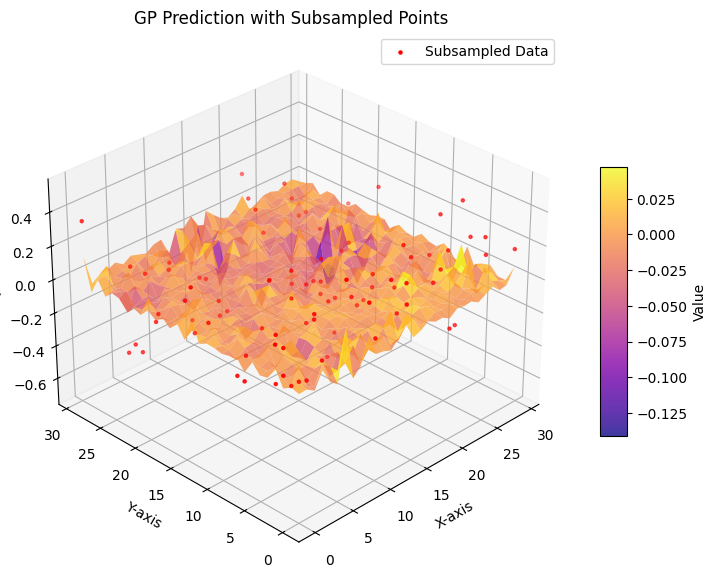

In [61]:
plot_gp_with_subsamples(mean.numpy(), mesh_size, subsample_idx, Y_noisy_subsampled,
                        title='GP Prediction with Subsampled Points', cmap='plasma')

In [62]:
# calculate the MSE

test_idx = np.setdiff1d(np.arange(num_nodes), subsample_idx)

Y_test = Y[test_idx]
mean_test = mean.numpy()[test_idx]

mse = np.mean((Y_test - mean_test.flatten())**2)
rmse = np.sqrt(mse)
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")

# calculate log marginal likelihood
log_marginal_likelihood = model.log_marginal_likelihood().numpy()
print(f"Log Marginal Likelihood: {log_marginal_likelihood:.4f}")

# NLPD (observation space)
mean_y, var_y = model.predict_y(X_full)
mean_y = mean_y.numpy().flatten()[test_idx]
var_y = var_y.numpy().flatten()[test_idx]
obs_true = Y_noisy[test_idx]
var_y = np.clip(var_y, 1e-12, None)
logp = -0.5 * (np.log(2 * np.pi * var_y) + (obs_true - mean_y) ** 2 / var_y)
nlpd = -np.mean(logp)
print(f"NLPD: {nlpd:.4f}")

MSE: 0.0358
RMSE: 0.1893
Log Marginal Likelihood: -105.2331
NLPD: 1.1637
